# **Fast Matrix Factorization for Online Recommendation with Implicit Feedback**

Groupe : Bouvier Oscar & Dupuy-Zini Alexandre

Source : https://arxiv.org/abs/1708.05024

---

# **Introduction**

This paper aims at improving *Matrix Factorization* (MF) methods with  implicit feedback. Those dimension reduction methods are very popular when it comes to recommandation systems. In that situation, a $users \times items$ matrix stores a binary information about an explicit interaction between a user and an item, and the question is then to guess the unconsumed items each user might want to interact with in the future. However, the main problem is that those matrices have very high dimensions, and their content is particularly sparse. That is why they are suitable for compressed sensing.

Matrix factorization focuses on reducing the dimension of the data by characterizing users and items by vectors of latent factors. Those vectors are built so that their product help recover the original $users \times items$ matrix. To achieve that, the available data can't be limited to the explicit feedback of the users, since they mostly do not provide any information (watching a video but not rating it, for example). In this case, it is challenging to know which implicit interaction happened to be negative. Consequently, as most entries are missing, the strategy used to weight this implicit feedback drastically affects this imbalanced learning problem.

Moreover, a particularity of recommandation systems is that their context is online : new users, items and interactions are continuously streaming in. Therefore, it becomes crucial to use adequate and efficient algorithms in order to cope with the real-time usage.

This paper introduces a new Matrix Factorization method aimed at learning from implicit feedback effectively while satisfying the requirement of online learning. In particular, it focuses on the three following points :
* the missing data is assigned a popularity-aware weighting scheme so that the algorithm can effectively learn from the implicit feedback
* a new algorithm named **eALS** is designed for efficiency and real-time online learning
* those improvements are carefully tested against different datasets and different contexts, and the hyperparameters are optimised with respect to two metrics.

In this notebook, we explain and implement this new method, and we then test it in different contexts of learning on large datasets. Finally, we discuss the contribution of this paper with regard to our experiments and our research on the subject.

---

# **1. Generic ALS for a whole-data based MF strategy**

There exists two main strategies when it comes to MF methods : sample based and whole-data based. While sample based strategies only use a sample of the missing data as negative samples in order to achieve a faster algorithm, the focus in this paper is to have a stronger predictiveness and fidelity. Therefore, a whole-data based strategy is chosen. The theory behind the optimization of a whole-data based MF method is detailed in this section.

## **1.1 Whole-data based Matrix Factorization method**

For $M$ users and $N$ items, let's denote $R \in \mathbb{R}^{M \times N}$ the binary user-item interaction matrix and $\mathcal{R}$ the set of non-zero user-item pairs (the true explicit interactions), which can be seen as the set of measures of the unknown $R^*$ matrix that we want to reconstruct. In order to achieve this reconstitution, MF methods map each user $u$ and each item $i$ to latent vectors in a feature space of size $K$. By denoting $p_u$ and $q_i$ their respective latent vectors, any entry $r_{ui}$ of the matrix $R$ is therefore estimated by the inner product $\hat{r}_{ui} = \langle p_u,q_i \rangle$. Moreover, we denote $P$ and $Q$ the respective matrices of users and items latent factors.

The learnable parameters $p_u$ and $q_i$ are optimized with respect to the following weighted and regularized regression cost function:
$$J=\sum\limits^{M}_{u=1} \sum\limits^{N}_{i=1} w_{ui}(r_{ui}-\hat{r}_{ui})^2 + \lambda \left( \sum\limits^{M}_{u=1}||p_u||^2 + \sum\limits^{N}_{i=1}||q_i||^2\right)$$

Each entry of $R$ is assigned a non-zero weight from the matrix $W$, which will be defined more precisely later. This enables to take into account all the data, including the implicit part.

## **1.2 Optimization of the ALS method**

One popular option to optimize this cost function is to use the Alternate Least Squares (ALS) method : it works by iteratively optimizing a parameter while leaving the others fixed. Here, this method iterates in an equivalent manner on each $p_u$ and each $q_i$, so the following calculus is done arbitrarily for a vector $p_u$. The cost function is then reduced to :
$$J_u = \sum\limits^{N}_{i=1}w_{ui}(r_{ui}-\hat{r}_{ui})^2 + \lambda ||p_u||^2 = ||W^u(r_u - Qp_u)||^2+\lambda ||p_u||^2$$
with $W^u=diag(w_{ui})$. The gradient is then :
$$\frac{\partial J_u}{\partial p_u}=-2(QW^u)^T(r_u - Qp_u) + 2\lambda p_u = 2Q^TW^uQp_u - 2Q^TW^ur_u+ 2\lambda p_u$$

The solution is here reduced to a Ridge Regression problem :
$$\left( Q^TW^uQ + \lambda I\right)p_u = Q^TW^ur_u$$
$$\implies p_u = \left( Q^TW^uQ + \lambda I\right)^{-1}Q^TW^ur_u$$

Even if there is no parameter to fine-tune beforehand like the learning rate of Gradient Descents methods, this solution has a major drawback : inverting a matrix is very expensive, and the repetition of this operation multiple times is a very complex situation. Here the complexity of fitting all parameters one time is $O ((M+N)K^3 + MNK^2)$ since inverting a matrix of shape $K^2$ is in $O(K^3)$.

## **1.3 ALS with uniform weighting**

A popular option to speed-up this complex computation is uniform weighting. There are several ways to apply a uniform weighting strategy. The first one is to apply a uniform weight of $1$ to all entries, whether they are implicit or explicit. However, in most situations, the ratio of implicit and explicit entries is strongly in favor of the implicit entries. Therefore, any learning from this strategy might be suboptimal. 

The second understading of the uniform strategy consists in setting the same weight $w_0$ to all missing entries only. By decomposing the $Q^TW^uQ$ matrix as $w_0Q^TQ + Q^T(W^u - W^0)Q$ where $W^0 = diag(w_0)$, we see that $w_0Q^TQ$ can be computed only once for all users and $(W^u - W^0)$ is a matrix with $|\mathcal{R}_u|$ non-zero entries. This enables to reduce the complexity of the ALS to $O((M+N)K^3 + |\mathcal{R}|K^2)$, which is slightly better.

However, this complexity is still higher than the one of a Stochastic Gradient Descent, which is common in the litterature for comparable methods. In addition, better performances are expected to be achieved by increasing $K$, at the expense of the complexity. The authors also argue that setting a uniform weighting might degrade the model's predictiveness, as it lacks flexibility and seems inadequate for real applications. In most real situations, few items are very frequent and most items are rare. That should influence the true negative weight of more popular but unconsumed items.



---

# **2. Fast eALS : details of the implementation**

To overcome this inefficiency problem, the authors introduce an element-wise optimization method that is suitable with any kind of weighting strategy. In addition, they adapt this with a popularity-aware weighting strategy to then optimize the computations. Finally, as the method validates the requirements of online learning, it is quickly adapted to the online learning problem.

## **2.1 Generic element-wise ALS Learner**

As an alternative solution to the speed-up proposed by the uniform weighting, the element-wise ALS learner is an optimization strategy that doesn't require any fixed distribution. Instead, it focuses on the optimization of each coordinate of the latent vectors, while leaving the others freezed. The gradient of the cost function with respect to the $f$ coordinate of the latent vector $p_u$ is :

\begin{align}
\frac{\partial J}{\partial p_{uf}} &= -2 \sum\limits^{N}_{i=1}w_{ui}q_{if}(r_{ui}-\hat{r}_{ui})+2\lambda p_{uf} 
\\&= -2 \sum\limits^{N}_{i=1}w_{ui}q_{if}(r_{ui}-\hat{r}_{ui}^f)+2 \left(\sum\limits^{N}_{i=1}w_{ui}q_{if}^2+\lambda \right)p_{uf} 
\end{align}

with $\hat{r}_{ui}^f = \hat{r}_{ui} - p_{uf}q_{if}$ in order to isolate $p_{uf}$. By setting this equation equal to zero, we get the following solution :
$$p_{uf} = \frac{\sum\limits^{N}_{i=1}w_{ui}q_{if}(r_{ui}-\hat{r}_{ui}^f)}{\sum\limits^{N}_{i=1}w_{ui}q_{if}^2+\lambda}$$

A similar result can be derived for any coordinate of a $q_i$ latent vector. Here is then the advantage of this strategy : avoiding the matrix inversion. Finally, by sharing some of the computations across coordinates and latent vectors, the complexity can be reduced to $O(MNK)$, which is better than the $O(K^3)$ of a matrix inversion.

This coordinate descent method also has the advantage to allow a more flexible weighting strategy which is choosen as an item-oriented (column-oriented) weighting plan in this paper. However, in the case of recommandation systems, it is hard to tell the difference between a negative feedback from an unknown feedback. This can be expressed as the rewriting of the following objective function :
$$J=\sum\limits_{(u,i) \in \mathcal{R}} w_{ui}(r_{ui}-\hat{r}_{ui})^2 +  \sum\limits^{M}_{u=1} \sum\limits_{i \notin \mathcal{R}_u} c_{i}\hat{r}_{ui}^2+ \lambda \left( \sum\limits^{M}_{u=1}||p_u||^2 + \sum\limits^{N}_{i=1}||q_i||^2\right)$$

with a weight $c_i$ for each item that illustrates the confidence that it is a true negative example when missed by a user. Those weights can be representative of the knowledge a content provider has about its items.

## **2.2 Popularity-aware Weighting Strategy**

In order to define the $c_i$, this paper focuses on another available information that content providers can exploit : which items were frequently promoted to users but recieved little attention ? This reflects the true negative feedback nature of an item for a user, and this information also has the property of being domain independant. The authors define $c_i$ as the following popularity-aware weight:
$$c_i = c_0 \frac{f_i^\alpha}{\sum^N_{j=1}f_j^\alpha}$$
with $f_i$ the popularity (its frequency in $R$), $c_0$ a constant assigning the general weight of the missing data and $\alpha$ an exponent to increase or decrease the significance of popular items.

## **2.3 Fast eALS**

However, it is worth noting that a lot of computations of the previous sections are common across the updated coordinates, and that precomputing those key intermediary values might spare some unnecessary complexity. In particular, we get the following solution for $p_{uf}$ from the previous rewriting of the objective function :
$$p_{uf} = \frac{\sum\limits_{i \in \mathcal{R}_u}w_{ui}q_{if}(r_{ui}-\hat{r}_{ui}^f) - \sum\limits_{i \notin \mathcal{R}_u}\hat{r}_{ui}^fc_iq_{if}}{\sum\limits_{i \in \mathcal{R}_u}w_{ui}q_{if}^2+\sum\limits_{i \notin \mathcal{R}_u}c_iq_{if}^2+\lambda}$$

Then, by rewriting some terms in order to maximise the shared computations, the authors introduce two caches $S^q = \sum\limits_{i=1}^{N}c_iq_i^Tq_i$ and $S^p=P^TP$ that can be computed once for all users and all items respectively. This final optimization is called the fast-eALS strategy and reduces the complexity to $O((M+N)K^2+|\mathcal{R}|K)$. This is $K$ times better than the original ALS strategy in complexity, and even linear of the $R$ matrix shape. Moreover, it is thus competitive with other contemporary optimization strategies while avoiding sampling the data or tuning an hyperparameter.

In the same time, the authors propose a faster computation method for evaluating the objective function, by reusing the previously introduced caches. This reduces the complexity of $O(MNK)$ for a direct computation to $O(|\mathcal{R}|+MK^2)$ with the item-oriented weighting strategy, especially for the missing data part of $R$.

Finally, this strategy accommodates easily to parallel computations since for each optimization, other parameters are either fixed or independant. This represents an advantage compared to other strategies using for example a SGD.

## **2.4 Online update**

All the previous accelerations enable to meet the requirements of online learning. In particular, the model is able to be incrementaly updated to quickly refresh a MF model given a new feedback. Given a new user-item interaction $(u,i)$, only $q_i$ and $p_u$ are updated. There is here an assumption that this update shouldn't affect the other latent factors much.

There is one particular parameter to handle a new interaction : the weight that is associated with it. This is up to the content provider to define it by taking into account the relation of this new interaction with past information. The higher it is, the more the latent vectors will be impacted by the recent information. Instant personalization might be very important for new users and older users might benefit from a refreshment in their recommandations.

In addition, such an update is quick to run for a new interaction thanks to the incremental online learning procedure. The complexity is $O(K^2+(|\mathcal{R}_u|+|\mathcal{R}_i|)K)$ as the update is considered independant of other items, users, and the global number of interactions.

---

# **3. Implementation**

One of the major challenges of this project was then to obtain an efficient implementation in Python. Indeed, as we're updating users and items at each iteration in the eALS method, we need to iterate over every user and every item many times with <code>for</code> loops without considering more efficient Python coding practicies. In this situation, Python, which is an interpretated language (and doesn't require code compilation), has a very bad efficicency in terms of computation time.

In order to approach the standard computation time of the original paper, we use Numba which is a JIT compiler that translates a subset of Python and NumPy code into faster machine code. A constraint associated to Numba is the heaviness of the code since not all NumPy calculus tricks are available. Moreover, it requires to specify beforehand the type of each variables used.

However, as Numba is quite restrictive in terms of data types used as input, we couldn't define objective sparse matrix in our implementation. Consequently, we define the $user \times item$ interaction matrix as two lists of numpy array : <code>user_lists</code> stores at index $i$ the array of users that explicitly interacted with item $i$, and <code>item_lists</code> stores at index $u$ the array of items that user $u$ interacted with.

Concerning the overall approach, we transform the rating datasets into implicit data, where each entry is marked as 0/1 indicating whether the user reviewed the item.

Moreover, for the weight of observed interactions, we set it uniformly as 1, which is a default setting used by the authors. It leads to some simplifications in the implemented methods by considering that the non-zero ratings' weights are directly set to 1 in our code. One can either consider ratings and specific weights by incorporating dedicated lists into the method's arguments, so as to generalize their use of non-implicit data.

In this section, after importing packages for the whole notebook, we first implement the ALS method and then the fast eALS method with its online component.

In the next subsections, we implement the ALS, which will be used as a baseline for performances evaluation, and the eALS method. Their performance will be compared by considering two metrics, namely the *Hit rate* and *NCDG* metrics. The first is useful to know if the predictions are generally accurate and the second adds a ranking scoring to the previous metric.

## Importing packages

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from tqdm.notebook import tqdm
import time

from numba import njit
from numba.experimental import jitclass
from numba import types, typed, typeof
from numba import float32, int32, int64, float64
from numba import types, typed, typeof
import matplotlib.pyplot as plt
import seaborn as sns
from numba.core.errors import NumbaPerformanceWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

## **3.1 ALS Implementation**

In [ ]:
import numpy as np

array_type = types.int64[:]

spec = [
    ('w0', float64),
    ('reg', float64 ),
    ('n_users', int64),
    ('n_items', int64),
    ('n_factors', int64),
    ('P', float64[:, :]),
    ('Q', float64[:, :]),
    ('SP', float64[:, :]),
    ('SQ', float64[:, :]),
    ('user_lists_train', types.ListType(array_type)),
    ('item_lists_train', types.ListType(array_type)),
    ('loss_history', types.ListType(float64)),
    ('hit_ratio_history', types.ListType(float64)),
    ('ncdg_history', types.ListType(float64))
]

@jitclass(spec)
class ALS:

  def __init__(self, n_users, n_items, n_factors = 10, w0 = 0.01, reg = 0.01, init_mean = 0, init_stdev = 0.01):
    self.w0 = w0
    self.reg = reg

    self.n_items = n_items
    self.n_users = n_users
    self.n_factors = n_factors
    
    self.P, self.Q = self.initialize_PQ(init_mean, init_stdev)

    self.SP = self.P.T @ self.P
    self.SQ = self.Q.T @self.Q

    self.loss_history = typed.List.empty_list(types.float64)
    self.hit_ratio_history = typed.List.empty_list(types.float64)
    self.ncdg_history = typed.List.empty_list(types.float64)

    self.user_lists_train = typed.List.empty_list(array_type)
    self.item_lists_train = typed.List.empty_list(array_type)

  #initializing function for user and item matrices
  def initialize_PQ(self, init_mean, init_stdev):
    init_P = np.random.normal(init_mean, init_stdev, size = (self.n_users, self.n_factors))
    init_Q = np.random.normal(init_mean, init_stdev, size = (self.n_items, self.n_factors))
    return init_P, init_Q

  #loading and memorizing function for user lists (for each item) 
  #and item lists (for each user)
  def initialize_lists(self, user_lists_train, item_lists_train):
    for l in user_lists_train:
      self.user_lists_train.append(l)
    for l in item_lists_train:
      self.item_lists_train.append(l)

  #Fitting function
  def fit(self, user_lists_train, item_lists_train, test_items=None, n_iter=1, compute_metrics=False):
    self.initialize_lists(user_lists_train, item_lists_train)
    for iter in range(n_iter):
      if compute_metrics:
        if test_items == None:
          return 'Error : need to specified test items to compute metrics.'
        self.compute_loss()

        hit_ratio, ncdg = self.compute_metrics(test_items)
        self.hit_ratio_history.append(hit_ratio)
        self.ncdg_history.append(ncdg)

      for i in range(self.n_items):
        self.update_item(i)
      for u in range(self.n_users):
        self.update_user(u)

  #Rating prediction function <p_u, q_i>
  def predict(self, u, i):
    return np.dot(self.P[u, :], self.Q[i, :])

  #Computing MSE loss function for ALS
  def compute_loss(self):
    cache_Q = np.zeros((self.n_factors, self.n_factors))

    for f in range(self.n_factors):
      for k in range(f+1):
        val = 0
        for i in range(self.n_items):
          val += self.Q[i, f] * self.Q[i, k]
        cache_Q[k, f] = val
        cache_Q[f, k] = val

    loss = self.reg * (np.sum(self.P ** 2) + np.sum(self.Q ** 2))

    for u in range(self.n_users):
      l = 0
      item_list = self.item_lists_train[u]
      for i in item_list:
        l += (1 - self.predict(u, i)) ** 2
      l *= 1 - self.w0
      l += self.w0 * cache_Q @ self.P[u, :] @ self.Q[u, :]
      loss += l

    self.loss_history.append(loss)

  #Function returning top scored items for a specific user (necessary to compute metrics)
  def get_top_ranked_items(self, u, n_top = 100):
    item_scores = np.zeros(self.n_items)
    for i in range(self.n_items):
      item_scores[i] = self.predict(u, i)
    top_ranked_items = item_scores.argsort()[-n_top:][::-1]
    return top_ranked_items

  #Function for computing Hit rate and NDCG
  def compute_metrics(self, test_items):
    hit_ratio = 0
    ncdg = 0
    for u in range(self.n_users):
      top_ranked_items = self.get_top_ranked_items(u)
      target_item = test_items[u]
      for i in range(len(top_ranked_items)):
        item = top_ranked_items[i]
        if item == target_item:
          hit_ratio += 1
          ncdg += np.log(2)/(np.log(i + 2))
    return hit_ratio/self.n_users, ncdg/self.n_users

  def update_user(self, u):
    #Items having interactions with user u 
    item_list = self.item_lists_train[u]

    #Computing left inversed matrix factor
    A = self.w0 * self.SP

    #Weight of observed interactions = 1
    weight = 1
    
    for f in range(self.n_factors):
      for k in range(self.n_factors):
        for i in item_list:
          A[f, k] += (weight - self.w0) * self.Q[i, f] * self.Q[i, k]

    #Adding regularization term
    A += self.reg * np.eye(self.n_factors)

    #Inversing the matrix
    A_inv = np.linalg.solve(A, np.eye(self.n_factors))

    #Computing right matrix factors
    b = np.zeros(self.n_factors)

    #0/1 binary rating for implicit data
    rating_non_zero = 1

    for k in range(self.n_factors):
      for i in item_list:
        b[k] += self.Q[i, k] * weight * rating_non_zero

    #Compute updated row of P
    new_p_u = A_inv @ b

    #updating cache SP
    for f in range(self.n_factors):
      for k in range(f+1):
        self.SP[k, f] = self.SP[f, k] - self.P[u, f] * self.P[u, k] + new_p_u[f] * new_p_u[k]
        self.SP[f, k] = self.SP[k, f]

    self.P[u, :] = new_p_u

  def update_item(self, i):
    #Users having interactions with item i
    user_list = self.user_lists_train[i]

    #Computing left factor matrix function
    A = self.w0 * self.SQ

    #Weight of observed interactions = 1
    weight = 1

    for f in range(self.n_factors):
      for k in range(self.n_factors):
        for u in user_list:
          A[f, k] += (weight - self.w0) * self.P[u, f] * self.P[u, k]

    #Adding regularization term
    A += self.reg * np.eye(self.n_factors)

    #inversing matrix
    A_inv = np.linalg.inv(A)

    #Computing right matrix factor function
    b = np.zeros(self.n_factors)

    #0/1 binary rating for implicit data
    rating_non_zero = 1

    for k in range(self.n_factors):  
      for u in user_list:
          b[k] += self.Q[u, k] * weight * rating_non_zero

    #Compute updated row of Q
    new_q_i = A_inv @ b

    #updating cache SQ
    for f in range(self.n_factors):
      for k in range(f+1):
        val = self.SQ[f, k] - self.Q[i, f] * self.Q[i, k] + new_q_i[f] * new_q_i[k]
        self.SQ[k, f] = val
        self.SQ[f, k] = val
    
    #updating item matrix
    self.Q[i, :] = new_q_i

## **3.2 Fast eALS Implementation**


In [ ]:
import numpy as np

array_type = types.int64[:]

spec_fast_eALS = [
    ('c0', float64),
    ('reg', float64 ),
    ('alpha', float64),
    ('init_mean', float64),
    ('init_stdev', float64),
    ('n_users', int64),
    ('n_items', int64),
    ('n_factors', int64),
    ('n_iters_online', int64),
    ('P', float64[:, :]),
    ('Q', float64[:, :]),
    ('SP', float64[:, :]),
    ('SQ', float64[:, :]),
    ('Ci', float64[:]),
    ('prediction_users', float64[:]),
    ('prediction_items', float64[:]),
    ('rating_users', float64[:]),
    ('rating_items', float64[:]),
    ('w_users', float64[:]),
    ('w_items', float64[:]),
    ('user_lists_train', types.ListType(array_type)),
    ('item_lists_train', types.ListType(array_type)),
    ('loss_history', types.ListType(float64)),
    ('hit_ratio_history', types.ListType(float64)),
    ('ncdg_history', types.ListType(float64))
]

@jitclass(spec_fast_eALS)
class fast_eALS:

  def __init__(self, n_users, n_items, n_factors = 10, c0 = 1, reg = 0.01, alpha = 0.5, 
               init_mean = 0, init_stdev = 0.01, n_iters_online = 1):
    self.c0 = c0
    self.reg = reg
    self.alpha = alpha
    self.init_mean = init_mean
    self.init_stdev = init_stdev

    self.n_items = n_items
    self.n_users = n_users
    self.n_factors = n_factors

    self.n_iters_online = n_iters_online   

    self.P, self.Q = self.initialize_PQ()
    self.SP = self.P.T @ self.P

    self.prediction_users = np.zeros(self.n_users)
    self.prediction_items = np.zeros(self.n_items)
    self.rating_users = np.zeros(self.n_users)
    self.rating_items = np.zeros(self.n_items)
    self.w_users = np.zeros(self.n_users)
    self.w_items = np.zeros(self.n_items)

    self.loss_history = typed.List.empty_list(float64)
    self.hit_ratio_history = typed.List.empty_list(float64)
    self.ncdg_history = typed.List.empty_list(float64)

    self.user_lists_train = typed.List.empty_list(array_type)
    self.item_lists_train = typed.List.empty_list(array_type)

  #initialization function for user and item matrices
  def initialize_PQ(self):
    init_P = np.random.normal(self.init_mean, self.init_stdev, size = (self.n_users, self.n_factors))
    init_Q = np.random.normal(self.init_mean, self.init_stdev, size = (self.n_items, self.n_factors))
    return init_P, init_Q

  #special initialization function for SQ
  def initialize_SQ(self):
    self.SQ = np.zeros((self.n_factors, self.n_factors))
    for f in range(self.n_factors):
      for k in range(f+1):
        val = 0
        for i in range(self.n_items):
          val += self.Q[i, f] * self.Q[i, k] * self.Ci[i]
        self.SQ[k, f] = val
        self.SQ[f, k] = val

  #loading and memorizing function for interacted user lists (for each item) 
  #and interacted item lists (for each user)
  def initialize_lists(self, user_lists_train, item_lists_train):
    for l in user_lists_train:
      self.user_lists_train.append(l)
    for l in item_lists_train:
      self.item_lists_train.append(l)

  #Rating prediction function <p_u, q_i>
  def predict(self, u, i):
    return np.dot(self.P[u, :], self.Q[i, :])

  #Computing Popularity aware weights
  def compute_Ci(self):
    popularities = np.array([len(self.user_lists_train[i]) for i in range(self.n_items)])
    p = (popularities /np.sum(popularities)) ** self.alpha
    self.Ci = (self.c0 / np.sum(p)) * p 

  #Fitting function
  def fit(self, user_lists_train, item_lists_train, test_items=None, n_iter=1, compute_metrics=True):
    self.initialize_lists(user_lists_train, item_lists_train)
    self.compute_Ci()
    self.initialize_SQ()

    for iter in range(n_iter):
      if compute_metrics:
        if test_items == None:
          return 'Error : need to specified test items to compute metrics.'

        self.compute_loss()
        hit_ratio, ncdg = self.compute_metrics(test_items)
        self.hit_ratio_history.append(hit_ratio)
        self.ncdg_history.append(ncdg)
      
      for u in range(self.n_users):
        self.update_user(u)
      for i in range(self.n_items):
        self.update_item(i)

  #Function returning top scored items for a specific user (necessary to compute metrics)
  def get_top_ranked_items(self, u, n_top = 100):
    item_scores = np.zeros(self.n_items)
    for i in range(self.n_items):
      item_scores[i] = self.predict(u, i)
    top_ranked_items = item_scores.argsort()[-n_top:][::-1]
    return top_ranked_items

  #Computing Hit rate and NCDG function
  def compute_metrics(self, test_items, n_top = 100):
    hit_ratio = 0
    ncdg = 0
    for u in range(self.n_users):
      top_ranked_items = self.get_top_ranked_items(u, n_top)
      target_item = test_items[u]
      for i in range(len(top_ranked_items)):
        item = top_ranked_items[i]
        if item == target_item:
          hit_ratio += 1
          ncdg += np.log(2)/(np.log(i + 2))
    return hit_ratio/self.n_users, ncdg/self.n_users

  def compute_metrics_for_user(self, u, target_item, n_top):
    top_ranked_items = self.get_top_ranked_items(u, n_top)
    hit_ratio = 0
    ncdg = 0
    for i in range(len(top_ranked_items)):
      item = top_ranked_items[i]
      if item == target_item:
        hit_ratio = 1
        ncdg = np.log(2)/(np.log(i + 2))
    return hit_ratio, ncdg

  #Loss function
  def compute_loss(self):
    loss = self.reg * (np.sum(self.P ** 2) + np.sum(self.Q ** 2))
    for u in range(self.n_users):
      item_list = self.item_lists_train[u]
      for i in item_list:
        prediction_score = self.predict(u, i)
        loss += (1 - prediction_score) ** 2 - self.Ci[i] * prediction_score ** 2
      loss += self.SQ @ self.P[u, :] @ self.P[u, :]
    self.loss_history.append(loss)

  #Algorithm core function for single update of P_u
  def update_user(self, u):
    #Items having interactions with user u 
    item_list = self.item_lists_train[u]

    if len(item_list) == 0:
      pass
    else :
      for i in item_list:
        #cache predictions score for user u
        self.prediction_items[i] = self.predict(u, i)

        #Binary 0/1 interaction rating for all items, implicit feedback
        self.rating_items[i] = 1

        #Weight of observed interaction = 1
        self.w_items[i] = 1
        
      #Computing updated row of P
      new_pu = np.zeros(self.n_factors)

      for f in range(self.n_factors):
        numerator, denominator = 0., 0.
        for k in range(self.n_factors):
          if k != f:
            numerator -= self.P[u, k] * self.SQ[f, k]
          
        for i in item_list:
          self.prediction_items[i] -=  self.P[u, f] * self.Q[i, f]
          numerator += (self.w_items[i] * self.rating_items[i] - (self.w_items[i]  - self.Ci[i]) * self.prediction_items[i]) * self.Q[i, f]
          denominator += (self.w_items[i]  - self.Ci[i]) * self.Q[i, f] * self.Q[i, f]

        denominator += self.SQ[f, f] + self.reg
        new_pu[f] = numerator/denominator

        #update prediction cache
        for i in item_list:
          self.prediction_items[i] +=  new_pu[f] * self.Q[i, f]

      #update cache SP
      for f in range(self.n_factors):
        for k in range(f+1):
          self.SP[f, k] = self.SP[f, k] - self.P[u, f] * self.P[u, k] + new_pu[f] * new_pu[k]
          self.SP[f, k] = self.SP[k, f] 

      #update user matrix
      self.P[u, :] = new_pu

  #Algorithm core function for single update of Q_i
  def update_item(self, i):
    #Users having interactions with item i 
    user_list = self.user_lists_train[i]

    if len(user_list) == 0:
      pass
    else:
      for u in user_list:
        #cache predictions score for user u
        self.prediction_users[u] = self.predict(u, i)

        #Binary 0/1 interaction rating for all users considering implicit feedback
        self.rating_users[u] = 1

        #Weight of observed interaction = 1
        self.w_users[u] = 1

      #computing updated row of Q
      new_qi = np.zeros(self.n_factors)
      for f in range(self.n_factors):
        numerator, denominator = 0., 0.
        for k in range(self.n_factors):
          if k != f:
            numerator -= self.Q[i, k] * self.SP[f, k]

        numerator *= self.Ci[i]
          
        for u in user_list:
          self.prediction_users[u] -=  self.P[u, f] * self.Q[i, f]
          numerator += (self.w_users[u]  * self.rating_users[u] - (self.w_users[u]  - self.Ci[i]) * self.prediction_users[u]) * self.P[u, f]
          denominator += (self.w_users[u] - self.Ci[i]) * self.P[u, f] ** 2

        denominator += (self.Ci[i] * self.SP[f,f]) + self.reg
        new_qi[f] = numerator/denominator

        #update prediction cache
        for u in user_list:
          self.prediction_users[u] +=  self.P[u, f] * new_qi[f]

      #update cache SQ
      for f in range(self.n_factors):
        for k in range(f+1):
          self.SQ[f, k] = self.SQ[f, k] - self.Q[i, f] * self.Q[i, k] * self.Ci[i] + new_qi[f] * new_qi[k] * self.Ci[i]
          self.SQ[k, f] = self.SQ[f, k]

      #update item matrix
      self.Q[i, :] = new_qi

  #Updating item list and user_list for online iteration
  def update_training_lists(self, u, i):
    old_item_lists_train = self.item_lists_train
    self.item_lists_train = typed.List.empty_list(array_type)

    for user in range(self.n_users):
      if user == u:
        new_item_list = np.zeros(len(old_item_lists_train[u]) + 1, dtype=int64)
        new_item_list[:-1] = old_item_lists_train[u]
        new_item_list[-1] = i
        self.item_lists_train.append(new_item_list)
      else:
        self.item_lists_train.append(old_item_lists_train[user])

    old_user_lists_train = self.user_lists_train
    self.user_lists_train = typed.List.empty_list(array_type)

    for item in range(self.n_items):
      if item == i:
        new_user_list = np.zeros(len(old_user_lists_train[i]) + 1, dtype=int64)
        new_user_list[:-1] = old_user_lists_train[i]
        new_user_list[-1] = u
        self.user_lists_train.append(new_user_list)
      else:
        self.user_lists_train.append(old_user_lists_train[item])

  #Updating function for online (user, item) interaction stream
  def update_online(self, u, i):
    self.update_training_lists(u, i)
    #Case where item has never been seen
    if self.Ci[i] == 0:
      self.Ci[i] = self.c0/self.n_items

      #Update SQ cache
      for f in range(self.n_factors):
       for k in range(f+1):
          val = self.SQ[f, k] + self.Q[i, f] * self.Q[i, k] * self.Ci[i]
          self.SQ[f, k] = val
          self.SQ[k, f] = val
    
    #Compute iterations update
    for iter in range(self.n_iters_online):
      self.update_user(u)
      self.update_item(i)

---

# **4. Experimentation**

In this section, we apply the previous implementations. The two methods are compared on two datasets of different sizes. The first one is the MovieLens 100k Dataset, and the second is the Yelp ratings Dataset. Then, we compare empirically the time complexity of both methods. Finally, we demonstrate the online learning protocol. All those results will be commented with regard to the ones published in the paper.

## **4.1 Experiments on the MovieLens 100k Dataset**

We will experiment first our algorithms on a dataset of around 100k movie ratings called MovieLens100k. This dataset is quite useful for our experimentations since it stores a relatively small number of users and items, which allows us to track the performance of the algorithms at each iteration with a reasonable computation time. However, this dataset has the property to have a lower sparsity level than standard practicional datasets.

For preprocessing, we follow common practice to transform ratings into binary interactions. We therefore transform the review dataset into implicit data, where each entry is marked as 0/1 indicating whether the user reviewed the item or not.

### **4.1.1 Downloading movielens100k dataset**

Let's first download and load the dataset.

In [ ]:
!pip install d2l==0.16.1 -q
!pip install -U mxnet-cu101==1.7.0 -q

from d2l import mxnet as d2l
from mxnet import gluon, np
import os
import pandas as pd

d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]

    return data, num_users, num_items

     |████████████████████████████████| 81kB 4.7MB/s 
     |███████████████████████████████▌| 834.1MB 1.3MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x55d53b8f0000 @  0x7f7122bc7615 0x55d50197306c 0x55d501a52eba 0x55d501975e8d 0x55d501a6799d 0x55d5019e9fe9 0x55d5019e4b0e 0x55d50197777a 0x55d5019e9e50 0x55d5019e4b0e 0x55d50197777a 0x55d5019e686a 0x55d501a687c6 0x55d5019e5ee2 0x55d501a687c6 0x55d5019e5ee2 0x55d501a687c6 0x55d5019e5ee2 0x55d501a687c6 0x55d5019e5ee2 0x55d50197769a 0x55d5019e5c9e 0x55d5019e4e0d 0x55d50197777a 0x55d5019e5a45 0x55d50197769a 0x55d5019e5a45 0x55d5019e4b0e 0x55d50197777a 0x55d5019e686a 0x55d5019e4b0e
     |████████████████████████████████| 846.0MB 20kB/s 


In [ ]:
data_100k, n_users_100k, n_items_100k = read_data_ml100k()

### **4.1.2 Dataset statistics**

To get a quick overview of the dataset, we observe some caracteristic numbers. The numbers of items (1643) and users (943) are way smaller than the number of interactions, leading to a low level of sparsity (around 0.937).

In [ ]:
print('Number of ratings : ', len(data_100k))
print('Number of items :   ', n_items_100k)
print('Number of users :   ', n_users_100k)
print('Sparsity level :     {:.04f}'.format(1 - len(data_100k)/( n_items_100k * n_users_100k)))

Number of ratings :  100000
Number of items :    1682
Number of users :    943
Sparsity level :     0.9370


### **4.1.3 Training procedure : leave one out train test split**

To train and test each method, we consider the *leave-one-out* evaluation procedure where the latest interaction of each user is held out for prediction and the models are trained on the remaining data. The two methods will be compared on the evaluation of the two following metrics.
* The *Hit ratio* counts the average number of *hits*, which is an indicator for telling wether or not the left-out test item for each user belongs to the top-recommended items. The number of top-recommended items is chosen manually but a common use for practitioners is $100$.
* The *NDCG* is quite close but takes into account the rank of the left-out test item of each user in the top-recommended items, assesssing a better performance metric if the target items have low rank.

More formally, considering for each user $u$ the left-out test item $i_u$, the top-recommended item set $R_u$ by the model, and the rank $r^{i_u}_{R_u}$ of item $i_u$ in $R_u$, we have :
* $\text{Hit-ratio} = \frac{1}{M}\sum_{u=1}^{M}\mathbb{1}(i_u \in R_u)$
* $\text{NDCG} = \frac{1}{M}\sum_{u=1}^{M}\frac{\log(2)}{\log(r^{i_u}_{R_u} +2)}\mathbb{1}(i_u \in R_u)$.

However, these metrics are quite expensive to compute since it requires to compute for each user and item their prediction scores of cost $O(MNK)$. That's why we will track performances considering these metrics only on small datasets like MovieLens100k which have low number of users and items.

The following cell prepares the dataset for the next section.

In [ ]:
# Reinitializing first item and user index to 0
data_100k.user_id -= 1
data_100k.item_id -= 1

# We split the dataset into train and test set considering Leave One Out
# split for each user.
data_train_100k = pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'timestamp'])
data_test_100k = pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'timestamp'])

for u in range(n_users_100k):
  frame = data_100k[data_100k.user_id == u]
  data_train_100k = data_train_100k.append(frame.iloc[:-1])
  data_test_100k = data_test_100k.append(frame.iloc[-1])

# Creation of useful lists for later
user_to_idx = {}
item_to_idx = {}

for i, id in enumerate(data_100k['user_id'].unique()):
  user_to_idx[id] = i

for j, id in enumerate(data_100k['item_id'].unique()):
  item_to_idx[id] = j

# Here we build the sparse interactions matrix of shape (items, users).
shape = n_items_100k, n_users_100k
tuples = []

for i in tqdm(range(len(data_train_100k))):
  user_id, item_id = data_train_100k.iloc[i]['user_id'], data_train_100k.iloc[i]['item_id']
  idx_u, idx_i = user_to_idx[user_id], item_to_idx[item_id]
  tuples.append((idx_i, idx_u))

# Delete duplicates
tuples = set(tuples)

r = [x for (x, y) in tuples] # x_coordinate
c = [y for (x, y) in tuples] # y_coordinate

data_tuples = [1] * len(r)

train_matrix_100k = sparse.csr_matrix((data_tuples, (r, c)), shape=shape)

# Test items list creation
test_items_100k = np.zeros(n_users_100k)

for i in tqdm(range(len(data_test_100k))):
  user_id, item_id = data_test_100k.iloc[i]['user_id'], data_test_100k.iloc[i]['item_id']
  idx_u, idx_i = user_to_idx[user_id], item_to_idx[item_id]
  test_items_100k[idx_u] = np.int64(idx_i)

test_items_100k = test_items_100k.tolist()

# Finally we transform as before the train matrix and the test dataset into numba processible lists.
user_lists_train_100k = [np.int64(sparse.find(train_matrix_100k[i, :])[1]) for i in tqdm(range(n_items_100k))]
item_lists_train_100k = [np.int64(sparse.find(train_matrix_100k[:, u])[0]) for u in tqdm(range(n_users_100k))]

### **4.1.4 Quick experimentations**

Our first experiment consists in tracking the performances of both algorithms using after 50 iterations of each, with unoptimized hyperparameters for Fast eALS.

#### Convergence with 20 latent factors

In [ ]:
import numpy as np

n_factors = 20
n_iter = 50
c0 = 4
alpha = 0.8
compute_metrics = True

print("Running ALS ...")
als = ALS(n_users_100k, n_items_100k, n_factors, w0=0.001, reg = 0.01)
als.fit(user_lists_train_100k, item_lists_train_100k, test_items_100k, n_iter, compute_metrics)
print("Running fast eALS ...")
fast_als = fast_eALS(n_users_100k, n_items_100k, n_factors, c0= c0, reg = 0.01, alpha = alpha)
fast_als.fit(user_lists_train_100k, item_lists_train_100k, test_items_100k, n_iter, compute_metrics)
print("Done !")

Running ALS ...
Running fast eALS ...
Done !


The first thing to check is the convergence of the algorithms. The ALS can be checked by looking at the MSE loss history. As expected, the loss is achieving a big decrease in the first interations until variating around a minimal value. This allows us to assess the coherence of our implementation. The same conclusions can be drawn for the fast eALS implementation.

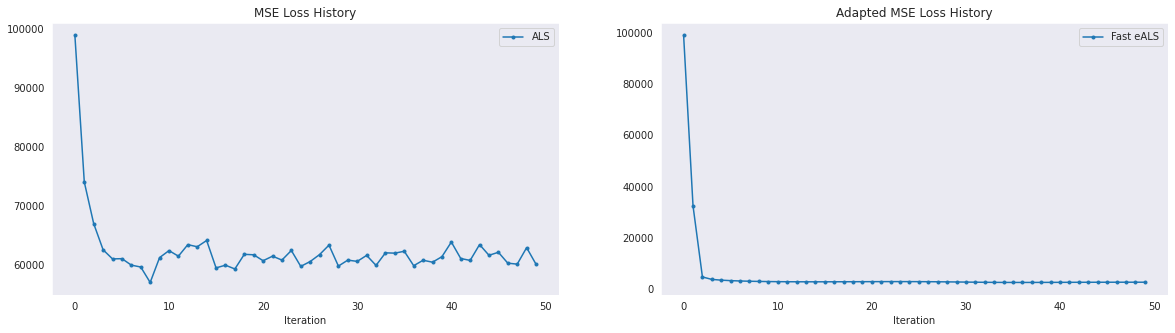

In [ ]:
sns.set_style("dark")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(als.loss_history, label='ALS', marker = '.')
ax1.set_xlabel('Iteration')
ax1.set_title('MSE Loss History')
ax1.legend()
ax2.plot(fast_als.loss_history, label='Fast eALS', marker = '.')
ax2.set_xlabel('Iteration')
ax2.set_title('Adapted MSE Loss History')
ax2.legend()

Secondly, let's compare the performances of the two models by looking at their respective Hit Ratio and NDCG history.

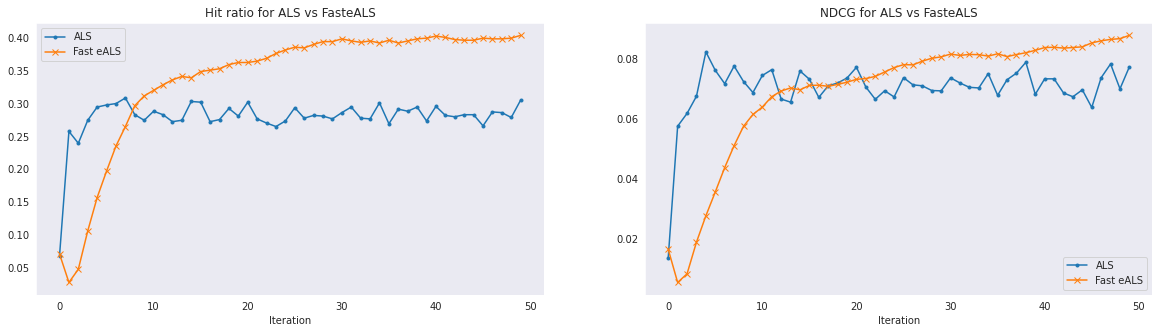

In [ ]:
sns.set_style("dark")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(als.hit_ratio_history, label='ALS', marker = '.')
ax1.plot(fast_als.hit_ratio_history, label='Fast eALS', marker = 'x')
ax1.set_xlabel('Iteration')
ax1.set_title('Hit ratio for ALS vs FasteALS')
ax1.legend()
ax2.plot(als.ncdg_history, label='ALS', marker = '.')
ax2.plot(fast_als.ncdg_history, label='Fast eALS', marker = 'x')
ax2.set_xlabel('Iteration')
ax2.set_title('NDCG for ALS vs FasteALS')
plt.legend()

We first observe that both methods assess strong practical performances. Indeed, the naive baseline performance for this dataset is around $\frac{100}{N} \approx 0.06$. Moreover, we observe that the Fast eALS method reaches way better performances after convergence, both in terms of *Hit ratio* and *NDCG*. In addition, it seems that the Fast eALS is more stable after convergence than the ALS alone.

However, it seems that the Fast eALS has a slower convergence rate than the standard ALS. This could be a consequence of the suboptimal random hyperparameter choice.

#### Time complexity with 50 latent factors

One of the key argument for the introduction of the fast eALS is the inefficiency of the ALS. Here we quickly check the improvement of time complexity for 50 latent factors.

In [ ]:
als_example = ALS(n_users_100k, n_items_100k, n_factors=50, w0=0.001, reg = 0.01)
print('Iteration time of ALS on MovieLens100k : ')
%timeit als_example.fit(user_lists_train_100k, item_lists_train_100k, test_items_100k, 1, False)

Iteration time of ALS on MovieLens100k : 
1 loop, best of 5: 3.04 s per loop


In [ ]:
fast_als_example = fast_eALS(n_users_100k, n_items_100k, n_factors=50, c0= c0, reg = 0.01, alpha = alpha)
print('Iteration time of Fast eALS on MovieLens100k : ')
%timeit fast_als_example.fit(user_lists_train_100k, item_lists_train_100k, test_items_100k, 1, False)

Iteration time of Fast eALS on MovieLens100k : 
1 loop, best of 5: 279 ms per loop


We can see that one Fast eALS iteration is as expected significantly faster than one ALS iteration, with a factor of around 10. This gap strongly increases especially when the number of latent factors increases.

### **4.1.5 Hyperparameter choice and further experimentation**

To get a better view of the performance of the fast eALS method, we now need to optimize the hyperparameters $\alpha$ and $c_0$. To this end, we follow the paper's method which consists in fixing $\alpha$ to 0 (uniform weighting) and finding the best $c_0$ over a list of possibilities, then fixing $c_0$ to the deduced value in order to find the best $\alpha$ using the same method.

In [ ]:
np.random.seed(42)

c0_list = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
alpha = 0
reg = 0.01
n_factors = 20
n_iter = 40

hit_ratios_vs_c0 = []
ncdgs_vs_c0 = []

for c0 in tqdm(c0_list):
  hr_tmp = 0
  ncdg_tmp = 0
  for _ in range(5):
    fast_als = fast_eALS(n_users_100k, n_items_100k, n_factors, c0, reg, alpha)
    fast_als.fit(user_lists_train_100k, item_lists_train_100k, None, n_iter, False)
    hr, ncdg = fast_als.compute_metrics(test_items_100k)
    hr_tmp += hr
    ncdg_tmp += ncdg
  hit_ratios_vs_c0.append(hr_tmp/5)
  ncdgs_vs_c0.append(ncdg_tmp/5)

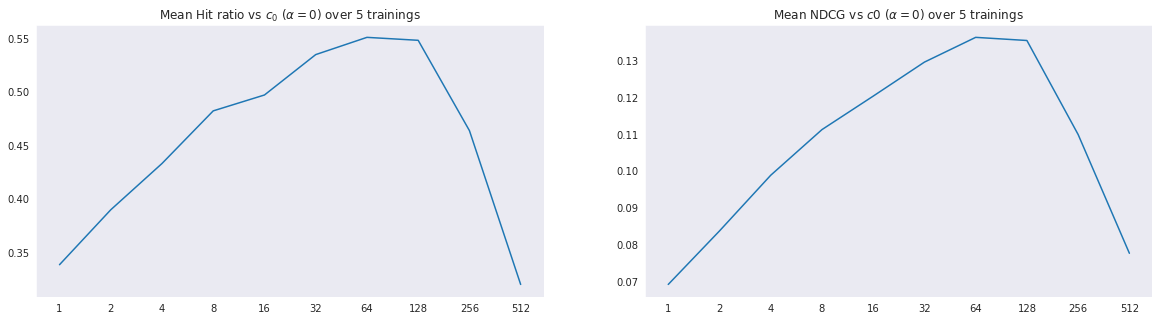

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
x = range(len(c0_list))
ax1.plot(hit_ratios_vs_c0)
ax1.set_title(r'Mean Hit ratio vs $c_0$ ($\alpha = 0$) over 5 trainings')
ax2.plot(ncdgs_vs_c0)
ax2.set_title(r'Mean NDCG vs $c0$ ($\alpha = 0$) over 5 trainings')
ax1.set_xticks(x)
ax2.set_xticks(x)
ax1.set_xticklabels(c0_list)
ax2.set_xticklabels(c0_list)
plt.show()

Fixing $\alpha$ to 0, we deduce that the best value is $c_0 = 64$.

Now let's choose a better $\alpha$, by using the previous $c_0$.

In [ ]:
np.random.seed(42)

alpha_list = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
reg = 0.01
n_factors = 20
n_iter = 40
c0 = 64

hit_ratios_vs_alpha = []
ncdgs_vs_alpha = []

for alpha in tqdm(alpha_list):
  hr_tmp = 0
  ncdg_tmp = 0
  for _ in range(5):
    fast_als = fast_eALS(n_users_100k, n_items_100k, n_factors, c0, reg, alpha)
    fast_als.fit(user_lists_train_100k, item_lists_train_100k, None, n_iter, False)
    hr, ncdg = fast_als.compute_metrics(test_items_100k)
    hr_tmp += hr
    ncdg_tmp += ncdg
  hit_ratios_vs_alpha.append(hr_tmp/5)
  ncdgs_vs_alpha.append(ncdg_tmp/5)

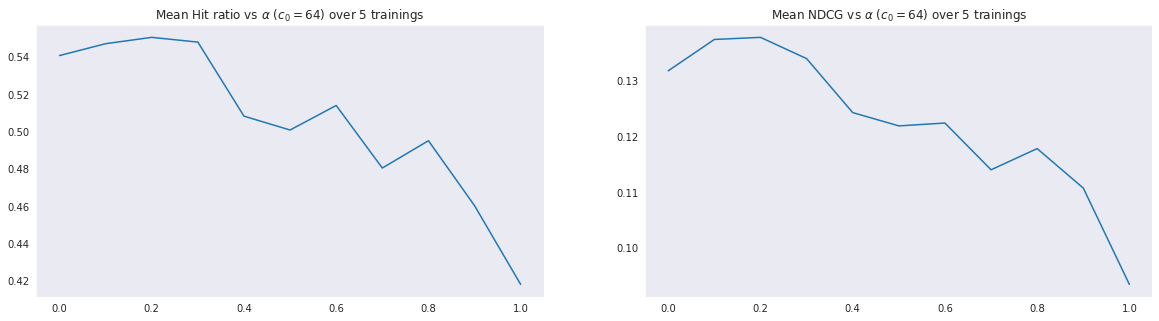

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
ax1.plot(alpha_list, hit_ratios_vs_alpha)
ax1.set_title(r'Mean Hit ratio vs $\alpha$ ($c_0 = 64$) over 5 trainings')
ax2.plot(alpha_list, ncdgs_vs_alpha)
ax2.set_title(r'Mean NDCG vs $\alpha$ ($c_0 = 64$) over 5 trainings')
plt.show()

Finally, we deduce that the best hyperparameters choice is $\alpha = 0.2$ and $c_0= 64$. This leads to the final training of the model, which is going to be a better comparison with the ALS trained before.

In [ ]:
import numpy as np

np.random.seed(42)

n_factors = 20
n_iter = 50
c0 = 64
alpha = 0.2
compute_metrics = True

fast_als = fast_eALS(n_users_100k, n_items_100k, n_factors, c0= c0, reg = 0.01, alpha = alpha)
fast_als.fit(user_lists_train_100k, item_lists_train_100k, test_items_100k, n_iter, compute_metrics)

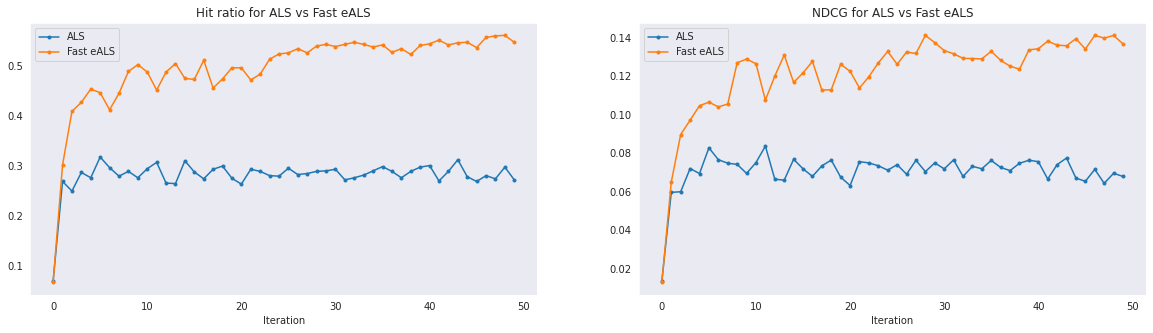

In [ ]:
sns.set_style("dark")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(als.hit_ratio_history, label='ALS', marker = '.')
ax1.plot(fast_als.hit_ratio_history, label='Fast eALS', marker = '.')
ax1.set_xlabel('Iteration')
ax1.set_title('Hit ratio for ALS vs Fast eALS')
ax1.legend()
ax2.plot(als.ncdg_history, label='ALS', marker = '.')
ax2.plot(fast_als.ncdg_history, label='Fast eALS', marker = '.')
ax2.set_xlabel('Iteration')
ax2.set_title('NDCG for ALS vs Fast eALS')
plt.legend()

The optimized Fast ALS reaches a plateau performance slightly above $0.5$ for the Hit Ratio and around $0.14$ for the NDCG on the dataset. Those performances are now way better than the ALS, whether it is by comparing those two metrics or the time complexity. Those results are the same than in the paper with respect to the different datasets used.

However, it is worth mentionning that the results obtained here appear to be less stable in the first dozen iterations than in the suboptimal hyperparameters choice.

## **4.2 Experiments on the Yelp ratings Dataset**

In the second part, we experiment on the Yelp ratings dataset, which compiles over 700k ratings made by 25k users over 25k items.

Unlike the previous dataset, the Yelp dataset has to property to have a high sparsity level.

For time computing constraints considerations, we choose to process only half of the dataset by subsampling the first half of the interactions and consider only the performance after convergence. Indeed, the dataset size doesn't allow us to compute in a reasonable time the metrics at each iteration.

As for the previous dataset, the same preprocessing and train/test split is applied here.

### **4.2.1 Downloading**

Here we download and load the full dataset.

In [ ]:
!wget https://raw.githubusercontent.com/hexiangnan/sigir16-eals/master/data/yelp.rating

--2021-03-24 16:47:28--  https://raw.githubusercontent.com/hexiangnan/sigir16-eals/master/data/yelp.rating
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18767261 (18M) [text/plain]
Saving to: ‘yelp.rating’

yelp.rating         100%[===================>]  17.90M  62.5MB/s    in 0.3s    

2021-03-24 16:47:30 (62.5 MB/s) - ‘yelp.rating’ saved [18767261/18767261]



In [ ]:
yelp_df = pd.read_csv('yelp.rating', delimiter = '\t', header=None).rename(columns={0 : 'user_id', 1 : 'item_id', 2 : 'rating', 3: 'timestamp'})

### **4.2.2 Dataset statistics**

We observe on the complete dataset a higher level of sparsity (around 0.9989), and a larger numbers of items and users (around 25k for both).

In [ ]:
print('Number of ratings : ', len(yelp_df))
print('Number of items :   ', len(yelp_df.item_id.unique()))
print('Number of users :   ', len(yelp_df.user_id.unique()))
print('Sparsity level :     {:0.4f}'.format(1 - len(yelp_df)/( len(yelp_df.item_id.unique())*len(yelp_df.user_id.unique()))))

Number of ratings :  731671
Number of items :    25815
Number of users :    25677
Sparsity level :     0.9989


### **4.2.3 Subsampling the dataset**

Considering computation time constraints, we only consider the first half of the complete dataset interactions.

In [ ]:
len_max = int(len(yelp_df)/2)
data_yelp = yelp_df[: len_max]

We observe on subsampled datasets less users (around 10k) and equivalent number of items (around 21k). Moreover, the sparsity remains similar (around 0.9983).

In the following, we set $M_{\text{yelp}}$ and $N_{\text{yelp}}$ respectively equal to the number of users and items of the yelp dataset.

In [ ]:
print('Number of ratings : ', len(data_yelp))
print('Number of items :   ', len(data_yelp.item_id.unique()))
print('Number of users :   ', len(data_yelp.user_id.unique()))
print('Sparsity level :     {:0.4f}'.format(1 - len(data_yelp)/( len(data_yelp.item_id.unique())*len(data_yelp.user_id.unique()))))

Number of ratings :  365835
Number of items :    21983
Number of users :    9905
Sparsity level :     0.9983


The following cell prepares the subsampled dataset for the following section.

In [ ]:
n_users_yelp = len(data_yelp.user_id.unique())
n_items_yelp = len(data_yelp.item_id.unique())

data_train_yelp = pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'timestamp'])
data_test_yelp = pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'timestamp'])

for u in tqdm(data_yelp.user_id.unique()):
  frame = data_yelp[data_yelp.user_id == u]
  data_train_yelp = data_train_yelp.append(frame.iloc[:-1])
  data_test_yelp = data_test_yelp.append(frame.iloc[-1])

user_to_idx_yelp = {}
item_to_idx_yelp = {}

for i, id in enumerate(data_yelp.user_id.unique()):
  user_to_idx_yelp[id] = i

for j, id in enumerate(data_yelp.item_id.unique()):
  item_to_idx_yelp[id] = j

test_items_yelp = np.zeros(n_users_yelp)

for i in tqdm(range(len(data_test_yelp))):
  user_id, item_id = data_test_yelp.iloc[i]['user_id'], data_test_yelp.iloc[i]['item_id']
  idx_u, idx_i = user_to_idx_yelp[user_id], item_to_idx_yelp[item_id]
  test_items_yelp[idx_u] = np.int64(idx_i)

test_items_yelp = test_items_yelp.tolist()

shape = n_items_yelp, n_users_yelp
tuples = []

for i in tqdm(range(len(data_train_yelp))):
  user_id, item_id = data_train_yelp.iloc[i].user_id, data_train_yelp.iloc[i].item_id
  idx_u, idx_i = user_to_idx_yelp[user_id], item_to_idx_yelp[item_id]
  tuples.append((idx_i, idx_u))

#enlever doublons
tuples = set(tuples)

r = [x for (x, y) in tuples] # x_coordinate
c = [y for (x, y) in tuples] # y_coordinate

yelp_data = [1] * len(r)

train_matrix_yelp = sparse.csr_matrix((yelp_data, (r, c)), shape=shape)

user_lists_train_yelp = [np.int64(sparse.find(train_matrix_yelp[i, :])[1]) for i in tqdm(range(n_items_yelp))]
item_lists_train_yelp = [np.int64(sparse.find(train_matrix_yelp[:, u])[0]) for u in tqdm(range(n_users_yelp))]

### **4.2.4 Experimentations**

In this section, we want to compare again the performances of the implemented methods, but here the dataset is considerably larger, even if it is subsampled.

We therefore compare the performances with 32 latent factors, and add a time measurement to quickly see the impact of the increased dataset size. The fast eALS hyperparameters of the previous section are kept there for simplification of the computation time, as explained hereafter.

In [ ]:
n_factors = 32
print("Running ALS ...")
als = ALS(n_users_yelp, n_items_yelp, n_factors, w0 = 0.001)
start_time_als = time.time()
als.fit(user_lists_train_yelp, item_lists_train_yelp, test_items_yelp, 10, False)
end_time_als = time.time()
print("Done in {:.02f} seconds".format(end_time_als - start_time_als))
print("Running fast eALS ...")
fast_als = fast_eALS(n_users_yelp, n_items_yelp, n_factors, c0 = 64, reg = 0.02, alpha = 0.5)
start_time_eals = time.time()
fast_als.fit(user_lists_train_yelp, item_lists_train_yelp, test_items_yelp, 30, False)
end_time_eals = time.time()
print("Done in {:.02f} seconds".format(end_time_eals - start_time_eals))

Running ALS ...
Done in 62.10 seconds
Running fast eALS ...
Done in 22.64 seconds


In [ ]:
print("Running ALS metrics ...")
start_time_als_m = time.time()
hit_ratio_als, ncdg_als = als.compute_metrics(test_items_yelp)
end_time_als_m = time.time()
print("Done in {:.02f} seconds".format(end_time_als_m - start_time_als_m))
print("Running fast eALS metrics ...")
start_time_eals_m = time.time()
hit_ratio_fast_als, ncdg_fast_als = fast_als.compute_metrics(test_items_yelp, 100)
end_time_eals_m = time.time()
print("Done in {:.02f} seconds".format(end_time_eals_m - start_time_eals_m))

Running ALS metrics ...
Done in 94.14 seconds
Running fast eALS metrics ...
Done in 93.92 seconds


Here we can observe that the ALS and fast eALS are quite fast to compute compared to the metrics computation, which takes several minutes to finish. The metrics are here more complicated to track, so we focus on the final metrics only and do not focus on finetuning the hyperparameters for example.

In [ ]:
print("            Hit-Ratio      NDCG")
print('ALS         {:04f}       {:04f}'.format(hit_ratio_als, ncdg_als))
print('Fast eALS   {:04f}       {:04f}'.format(hit_ratio_fast_als, ncdg_fast_als))

            Hit-Ratio      NDCG
ALS         0.016759       0.003215
Fast ALS    0.038163       0.007515


However, both methods reache good performances on this dataset too, by overperforming again the naive baseline for Hit-ratio ($\frac{100}{N_{\text{yelp}}} \approx 0.0045$). Once again, the fast eALS method achieves better performances than the ALS after convergence, which demonstrates the better efficiency of this method.

## **4.3 Time complexity analysis**

The objective of this section is to study and compare the time complexity of both methods.

Let's recall the theoric time complexity : considering $M$ the number of items, $N$ the number of users, $K$ the number of latent factors and $|\mathcal{R}|$ the number of interactions .
* ALS : $O ((M+N)K^3 + |\mathcal{R}|K^2)$
* Fast ALS : $O((M+N)K^2+|\mathcal{R}|K)$

To study the influence of each term, we will then consider 3 different datasets: 
*   MovieLens Dataset containing around 100k interactions between around 1k users and 1k items.
*   Yelp dataset containing around 350k interactions between around 10k users and 20k items
*   Yelp 100k Dataset containing 100k interactions between around 10k users and 20k items.

The Yelp 100k dataset is simply a subsample of the Yelp dataset but chosen to have the same number of interactions than the MovieLens Dataset, and the same number of user and items than the Yelp Dataset so as to study influence of $|\mathcal{R}|$ and $(M+N)$ terms over varying number of factors $K$.

The next cell defines a helper function.


In [ ]:
def compute_iteration_time(model, data_id = 'movielens'):
  if data_id == 'movielens':
    start = time.time()
    model.fit(user_lists_train_100k, item_lists_train_100k, None, 1, False)
    return time.time() - start
  
  if data_id == 'yelp':
    start = time.time()
    model.fit(user_lists_train_yelp, item_lists_train_yelp, None, 1, False)
    return time.time() - start

  if data_id == 'yelp100k':
    start = time.time()
    model.fit(user_lists_train_yelp_100k, item_lists_train_yelp_100k, None, 1, False)
    return time.time() - start

  else:
    return 'Data_id error'

### **4.3.1 Creation of the 100k subsample Yelp dataset**

Here we create the only missing dataset.

In [ ]:
print(f'Number of users YELP : {n_users_yelp}')
print(f'Number of items YELP : {n_items_yelp}')

Number of users YELP : 9905
Number of items YELP : 21983


In [ ]:
data_yelp_100k = yelp_df[: int(1e5)]

data_train_yelp_100k = pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'timestamp'])
data_test_yelp_100k = pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'timestamp'])

for u in tqdm(data_yelp_100k.user_id.unique()):
  frame = data_yelp_100k[data_yelp_100k.user_id == u]
  data_train_yelp_100k = data_train_yelp_100k.append(frame.iloc[:-1])
  data_test_yelp_100k = data_test_yelp_100k.append(frame.iloc[-1])

user_to_idx = {}
item_to_idx = {}

for i, id in enumerate(data_train_yelp['user_id'].unique()):
  user_to_idx[id] = i

for j, id in enumerate(data_train_yelp['item_id'].unique()):
  item_to_idx[id] = j

shape = n_items_yelp, n_users_yelp

tuples = []

for i in tqdm(range(len(data_train_yelp_100k))):
  user_id, item_id = data_train_yelp_100k.iloc[i]['user_id'], data_train_yelp_100k.iloc[i]['item_id']
  idx_u, idx_i = user_to_idx[user_id], item_to_idx[item_id]
  tuples.append((idx_i, idx_u))

#discard duplicates
tuples = set(tuples)

r = [x for (x, y) in tuples] # x_coordinate
c = [y for (x, y) in tuples] # y_coordinate

data_tuples = [1] * len(r)

train_matrix_yelp_100k = sparse.csr_matrix((data_tuples, (r, c)), shape=shape)

user_lists_train_yelp_100k = [np.int64(sparse.find(train_matrix_yelp_100k[i, :])[1]) for i in tqdm(range(n_items_yelp))]
item_lists_train_yelp_100k = [np.int64(sparse.find(train_matrix_yelp_100k[:, u])[0]) for u in tqdm(range(n_users_yelp))]

### **4.3.2 Computing computation times for every datasets**

This section is dedicated to the calculation of the computation times for different models, datasets, and latent factors.

In [ ]:
fast_als_time_complexity_100k = []
als_time_complexity_100k = []

fast_als_time_complexity_yelp_100k = []
als_time_complexity_yelp_100k = []

fast_als_time_complexity_yelp = []
als_time_complexity_yelp = []

n_factors_list = [10, 20, 30, 50, 80, 100, 150]

for factor in tqdm(n_factors_list):

  als_100k = ALS(n_users_100k, n_items_100k, factor)
  fast_als_100k = fast_eALS(n_users_100k, n_items_100k, factor)

  als_time_complexity_100k.append(compute_iteration_time(als_100k, data_id = 'movielens'))
  fast_als_time_complexity_100k.append(compute_iteration_time(fast_als_100k, data_id = 'movielens'))

  als_yelp = ALS(n_users_yelp, n_items_yelp, factor)
  fast_als_yelp = fast_eALS(n_users_yelp, n_items_yelp, factor)

  als_time_complexity_yelp_100k.append(compute_iteration_time(als_yelp, data_id = 'yelp100k'))
  fast_als_time_complexity_yelp_100k.append(compute_iteration_time(fast_als_yelp, data_id = 'yelp100k'))

  als_yelp = ALS(n_users_yelp, n_items_yelp, factor)
  fast_als_yelp = fast_eALS(n_users_yelp, n_items_yelp, factor)

  als_time_complexity_yelp.append(compute_iteration_time(als_yelp, data_id = 'yelp'))
  fast_als_time_complexity_yelp.append(compute_iteration_time(fast_als_yelp, data_id = 'yelp'))

### **4.3.3 Computation times vs methods**

We compare here the computation times for both methods over each dataset separately.

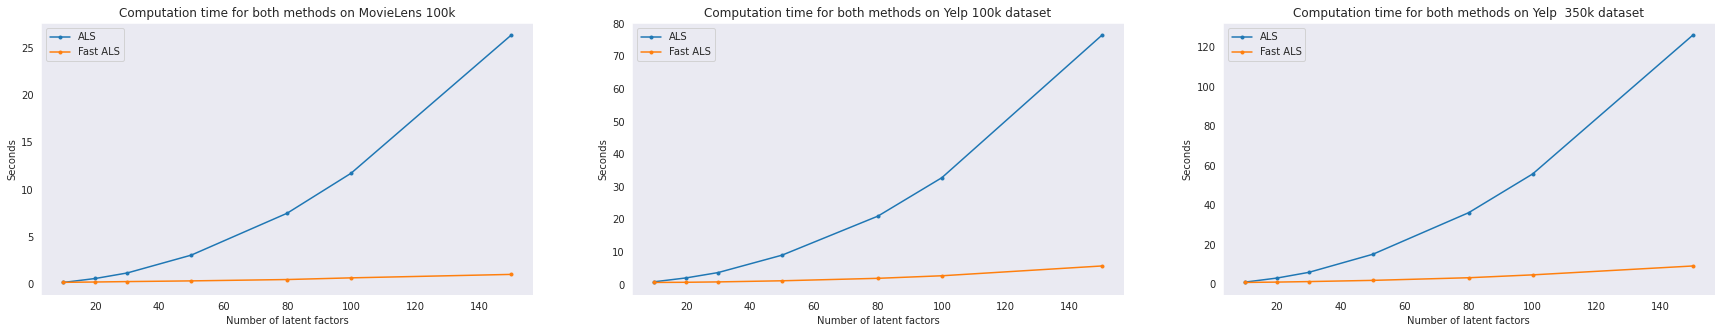

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 5))

ax1.plot(n_factors_list, als_time_complexity_100k, marker = '.', label = 'ALS')
ax1.plot(n_factors_list, fast_als_time_complexity_100k, marker = '.', label = 'Fast ALS')
ax1.legend()
ax1.set_xlabel('Number of latent factors')
ax1.set_ylabel('Seconds')
ax1.set_title('Computation time for both methods on MovieLens 100k')

ax2.plot(n_factors_list, als_time_complexity_yelp_100k, marker = '.', label = 'ALS')
ax2.plot(n_factors_list, fast_als_time_complexity_yelp_100k, marker = '.', label = 'Fast ALS')
ax2.legend()
ax2.set_xlabel('Number of latent factors')
ax2.set_ylabel('Seconds')
ax2.set_title('Computation time for both methods on Yelp 100k dataset')

ax3.plot(n_factors_list, als_time_complexity_yelp, marker = '.', label = 'ALS')
ax3.plot(n_factors_list, fast_als_time_complexity_yelp, marker = '.', label = 'Fast ALS')
ax3.legend()
ax3.set_xlabel('Number of latent factors')
ax3.set_ylabel('Seconds')
ax3.set_title('Computation time for both methods on Yelp  350k dataset')

plt.show()

We can see that Fast eALS methods clearly outperforms ALS in terms of computation time over every datasets. These graphs demonstrate the key advantage of Fast eALS in speeding-up the algorithm computation, especially when the complexity of the model (number of latent factors) increases.

### **4.3.4 Computation time vs varying size of number and items.**

We compare here the computation times for both methods over Yelp100k dataset and MovieLens dataset, ie dataset having same number of interactions but varying number of items and users. We study separately the influence of the varying terms for each method.

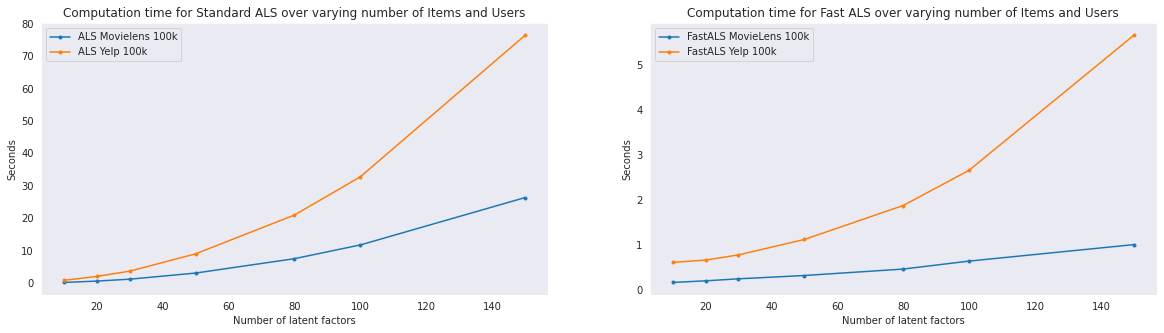

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

ax1.plot(n_factors_list, als_time_complexity_100k, marker = '.', label = 'ALS Movielens 100k')
ax1.plot(n_factors_list, als_time_complexity_yelp_100k, marker = '.', label = 'ALS Yelp 100k')
ax1.legend()
ax1.set_xlabel('Number of latent factors')
ax1.set_ylabel('Seconds')
ax1.set_title('Computation time for Standard ALS over varying number of Items and Users')

ax2.plot(n_factors_list, fast_als_time_complexity_100k, marker = '.', label = 'FastALS MovieLens 100k')
ax2.plot(n_factors_list, fast_als_time_complexity_yelp_100k, marker = '.', label = 'FastALS Yelp 100k')
ax2.legend()
ax2.set_xlabel('Number of latent factors')
ax2.set_ylabel('Seconds')
ax2.set_title('Computation time for Fast ALS over varying number of Items and Users')

plt.show()

Here the factor $(M + N)$ is different for both curves but we have same (approximate) number of interactions meaning that |$\mathcal{R}$| is identical.

We observe as expected a faster-exploding computation time for the standard ALS (at a cube rate) for low latent factors (around 50) while the exploding delay is higly decayed for the Fast eALS method (around 80 latent factors).

Moreover we can see that the factor $(M+N)$ is as expected proeminent in computation time for both methods and especially for the Fast eALS in which computation is 6 times longer on Yelp100k dataset compared to the MovieLens dataset.

### **4.3.5 Computation time vs varying number of interactions**

We compare here the computation times for both methods over Yelp100k dataset and the complete Yelp dataset, ie datasets having different numbers of interactions but same number of items and users.

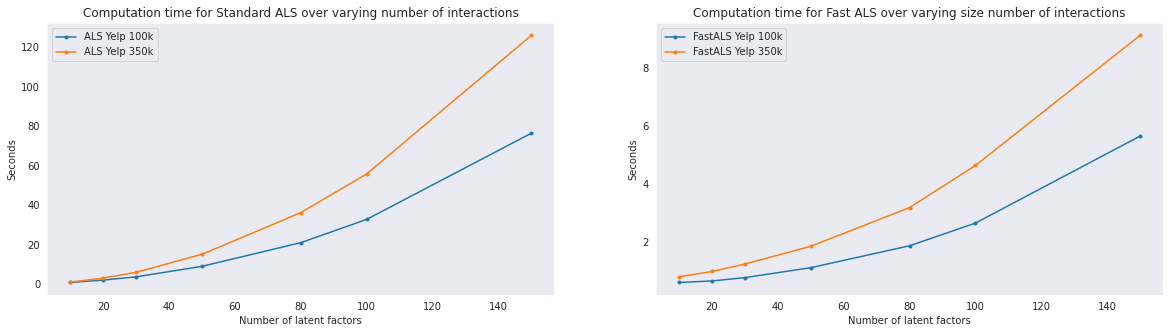

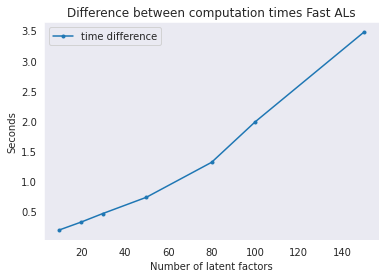

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (20, 5))

ax1.plot(n_factors_list, als_time_complexity_yelp_100k, marker = '.', label = 'ALS Yelp 100k')
ax1.plot(n_factors_list, als_time_complexity_yelp, marker = '.', label = 'ALS Yelp 350k')
ax1.legend()
ax1.set_xlabel('Number of latent factors')
ax1.set_ylabel('Seconds')
ax1.set_title('Computation time for Standard ALS over varying number of interactions')

ax2.plot(n_factors_list, fast_als_time_complexity_yelp_100k, marker = '.', label = 'FastALS Yelp 100k')
ax2.plot(n_factors_list, fast_als_time_complexity_yelp, marker = '.', label = 'FastALS Yelp 350k')
ax2.legend()
ax2.set_xlabel('Number of latent factors')
ax2.set_ylabel('Seconds')
ax2.set_title('Computation time for Fast ALS over varying size number of interactions')

plt.show()

plt.plot(n_factors_list, np.array(fast_als_time_complexity_yelp) -  np.array(fast_als_time_complexity_yelp_100k), marker = '.', label='time difference')
plt.legend()
plt.xlabel('Number of latent factors')
plt.ylabel('Seconds')
plt.title('Difference between computation times Fast ALs')

plt.show()

Here the number of items and users is similar for both curves, meaning that we study the influence of the $|\mathcal{R}|$ term (which differs between the two datasets).

As expected, we can observe that increasing $|\mathcal{R}|$ provokes a longer computation time. However, as expected, its influence is less proeminent compared to the $(M+N)$ factor.

In the particular case of the Fast eALS, we can isolate the influence of this term by substracting the two computation times leading to a theorically $O(K(|\mathcal{R}_2| - |\mathcal{R}_1|))$ time complexity (where $|\mathcal{R}_1|$ and $|\mathcal{R}_2|$ denotes the respective number of interaction for each dataset). We effectively observe this approximately linear growth of computation time on the last figure.

## **4.4 Online protocol for Fast eALS**

Lastly, as all previous experiments focused on the offline learning procedure, this section is dedicated to the online protocol. This part is supposed to be the most useful for real situations, since it is the one use in pratice.

To recreate this particular context, a hold-out is praticed on the last 10% data of the training dataset. Those will be iteratively distilled to the model to simulate the streaming of new user/item interactions. This does not exclude the creation of a new user or a new item.

For this section, we use the MovieLens 100k dataset again to get faster experiments.



### **4.4.1 Dataset splitting**

Here we split the dataset into two parts separated according to their time of arrival in the dataset. This lowers the number of interactions, but also lowers the number of users and items.

In [ ]:
data_train_online = data_train_100k[:int(0.9 * len(data_100k))]
data_test_online = data_train_100k[int(0.9 * len(data_100k)):]

n_items_online = len(data_train_online.item_id.unique())
n_users_online = len(data_train_online.user_id.unique())

print(f"Original Dataset :        {n_users_100k} users and {n_items_100k} items")
print(f"Online Training Dataset : {n_users_online} users and {n_items_online} items")

Original Dataset :        943 users and 1682 items
Online Training Dataset : 862 users and 1677 items


In [ ]:
user_to_idx = {}
item_to_idx = {}

for i, id in enumerate(data_train_100k['user_id'].unique()):
  user_to_idx[id] = i

for j, id in enumerate(data_train_100k['item_id'].unique()):
  item_to_idx[id] = j

shape = n_items_100k, n_users_100k

tuples = []

for i in tqdm(range(len(data_train_online))):
  user_id, item_id = data_train_online.iloc[i]['user_id'], data_train_online.iloc[i]['item_id']
  idx_u, idx_i = user_to_idx[user_id], item_to_idx[item_id]
  tuples.append((idx_i, idx_u))

tuples = set(tuples)

r = [x for (x, y) in tuples] # x_coordinate
c = [y for (x, y) in tuples] # y_coordinate

data_tuples_online = [1] * len(r)

train_matrix_online = sparse.csr_matrix((data_tuples_online, (r, c)), shape=shape)

user_lists_train_online = [np.int64(sparse.find(train_matrix_online[i, :])[1]) for i in tqdm(range(n_items_100k))]
item_lists_train_online = [np.int64(sparse.find(train_matrix_online[:, u])[0]) for u in tqdm(range(n_users_100k))]

### **4.4.2 Experiments**

The model trained here is based on the hyperparameters choice that was studied earlier. The two main points that are studied in the paper are the number of iterations required for the fast eALS to converge and the optimal weight of a new interaction. However, the second point about $w_{new}$ cannot be investigated here because of the choice we made to use Numba to get a faster implementation. Indeed, we cannot update $w_{ui}$ strictly for $u$ and $i$. Nevertheless, this value is in pratice discussed by the content provider himself to fit his idea of how much risk the recommandation system has to take.


#### **Sanity check**

First, let's check the process of testing the online learning process. Here, we create a fast eALS model where some of the original inputs are missing. We can check after processing the test online learning that additionnal data have been stored.

In [ ]:
n_factors = 20
c0 = 64
reg = 0.01
alpha = 0.2
n_iter = 40

fast_als_online = fast_eALS(n_users_100k, n_items_100k, n_factors, c0, reg, alpha)
fast_als_online.fit(user_lists_train_online, item_lists_train_online, test_items_online, n_iter, False)

In [ ]:
fao_metrics = fast_als_online.compute_metrics(test_items_online, 100)
print('Hit ratio : {:.05f}\nNDCG : {:.05f}'.format(fao_metrics[0], fao_metrics[1]))

Hit ratio : 0.18240
NDCG : 0.04166


In [ ]:
test_items_online = [item_to_idx[data_test_online.item_id.iloc[i]] for i in range(len(data_test_online))]
new_interactions = [(user_to_idx[data_test_online.user_id.iloc[i]], item_to_idx[data_test_online.item_id.iloc[i]]) for i in range(len(data_test_online))]

for u, i in tqdm(new_interactions):
  fast_als_online.update_online(u, i)

In [ ]:
print(f'There used to be {sum([len(x) for x in user_lists_train_online])} items')
print(f'Now, there are {sum([len(x) for x in fast_als_online.user_lists_train])} items')

There used to be 90000 items
Now, there are 99057 items


#### **Number of iterations needed to converge**

Here, we are going to monitor the performance of the model if it meets a new interaction. We proceed by training the full model on the training data, and then, on each new interaction, we get the metrics (hit ratio and NDCG) for this specific user and item, and then the model is updated with respect to the number of iterations applied to a new interaction.

In [ ]:
hit_ratios_vs_iterations, ndcgs_vs_iterations = [], []
max_n_iter_online = 6

for nio in tqdm(range(max_n_iter_online)):
  hr_tmp, ndcg_tmp = 0, 0
  for _ in range(5):
    fast_als_online = fast_eALS(n_users_100k, n_items_100k, n_factors, c0, reg, alpha, n_iters_online=nio)
    fast_als_online.fit(user_lists_train_online, item_lists_train_online, None, n_iter, False)
    for u, i in new_interactions:
      hit_ratio, ndcg = fast_als_online.compute_metrics_for_user(u, i, 100)
      fast_als_online.update_online(u, i)
      hr_tmp += hit_ratio
      ndcg_tmp += ndcg
  hit_ratios_vs_iterations.append(hr_tmp/(5*len(new_interactions)))
  ndcgs_vs_iterations.append(ndcg_tmp/(5*len(new_interactions)))

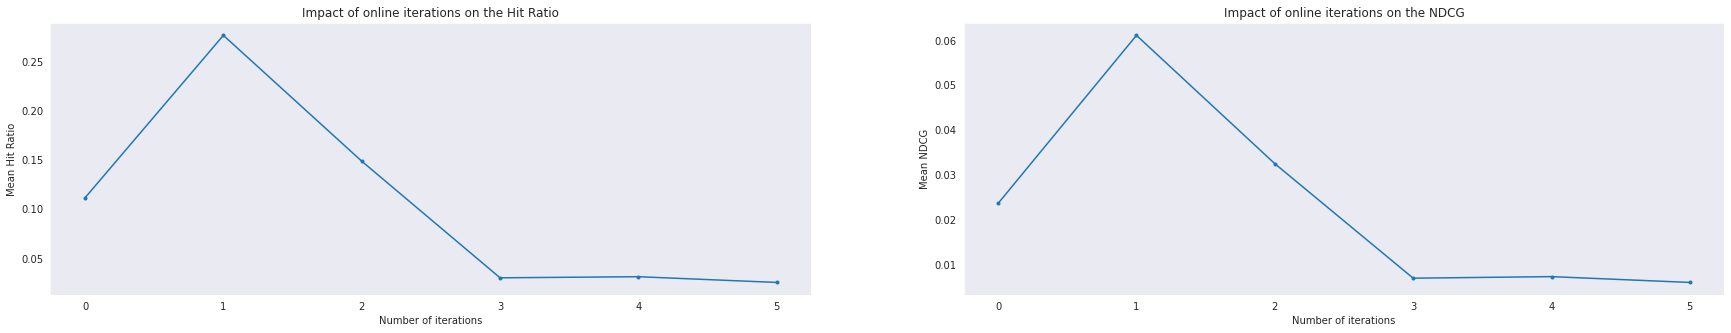

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 5))

ax1.plot(range(max_n_iter_online), hit_ratios_vs_iterations, marker = '.')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Mean Hit Ratio')
ax1.set_title('Impact of online iterations on the Hit Ratio')

ax2.plot(range(max_n_iter_online), ndcgs_vs_iterations, marker = '.')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Mean NDCG')
ax2.set_title('Impact of online iterations on the NDCG')

plt.show()

As in the paper, we find that a single pass of update on each new interaction gives the best results. A model that is never updated has poor metrics, and the higher the number of iterations is, the lower the future metrics are. Here, the results differ from the paper, but the reason remains uncertain. It probably relies in the way we implemented our weighting strategy : it is probably too heavy on the new interactions when there are too many iterations, and that distorts the latent vectors for the user and the item concerned. Another difference relies in the number of latent factors used, that was much higher in the paper than in this experiment. In that situation, latent vectors are less stable andd doing too much iterations probably brings them too close and forgets all the past information.

However, computing this experiments is too time consuming because of the multiple models to train and then to iteratively update with several iterations on each new interaction.

#### **Fast update in an online context**

Here we want to assess that updating with one iteration is suitable in a context of new interactions constantly streaming in.

In [ ]:
n_factors_list = [16, 32, 64, 128, 256, 512]
mean_update_time = []

for n_f in tqdm(n_factors_list):
  fast_als_online = fast_eALS(n_users_100k, n_items_100k, n_f, c0, reg, alpha)
  fast_als_online.fit(user_lists_train_online, item_lists_train_online, test_items_online, n_iter, False)

  start_time_fao = time.time()
  for u, i in new_interactions:
    fast_als_online.update_online(u, i)
  end_time_fao = time.time()
  time_per_update = (end_time_fao - start_time_fao)/len(new_interactions)
  mean_update_time.append(time_per_update)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


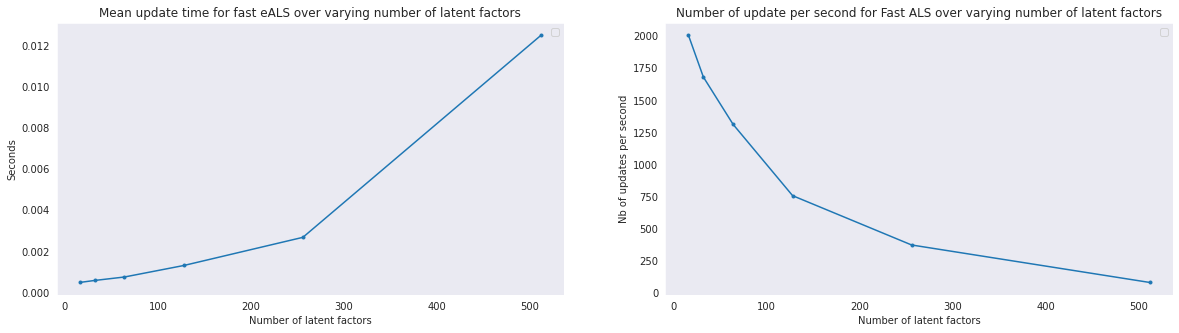

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

ax1.plot(n_factors_list, mean_update_time, marker = '.')

ax1.set_xlabel('Number of latent factors')
ax1.set_ylabel('Seconds')
ax1.set_title('Mean update time for fast eALS over varying number of latent factors')

ax2.plot(n_factors_list, [1/x for x in mean_update_time], marker = '.')
ax2.set_xlabel('Number of latent factors')
ax2.set_ylabel('Nb of updates per second')
ax2.set_title('Number of updates per second for Fast ALS over varying number of latent factors')

plt.show()

This section proves that the online process is feasible, even when the number of latent factors grows. This implementation might underperform for a more complex recommandation system, but this already demonstrates the ability of the Fast ALS to cope with online learning, by being able to update few hundreds or thousands of interactions per second. Moreover, this process can be parallelized and take into account more interactions per second to fit a real situation with a higher number of factors.

---

# **5. Discussion**

In this last section, we discuss more globally the results obtained in this notebook to enlighten our reading of the contributions of this paper.

## **5.1 Global comments on the experiments**

Generally, our experiments confirmed the theory and the practice of the paper. We could implement a fast eALS that proved its time efficiency, its performance according to the two metrics tracked and its online context adaptation. We focused on comparing the fast eALS to its generic implementation as the ALS. It outperformed on multiple criteria. The authors also compared the fast eALS to other whole-data based methods like the RCD (Randomized block Coordinate Descent), which is considered the state of the art implicit MF method. The BPR (Bayesian personalized ranking) is another solution used as a comparison since it has a lower time complexity in theory, even if it is a sample based method. The general conclusion is that the fast eALS outperforms in the experiments most other methods, wether it is by a better prediction recall or by a more effective and efficient process.

It also relies on a relaxation of the underlying strategy for weighting the missing data and on a possible adaptation to the online context. Both additions are crucial for recommandation systems and open new opportunities.

## **5.2 Work continuation**

However, a more recent version of this paper has been published in early 2019. It mainly updates the strategy to weight the missing data, while leaving untouched the following resolution method. It uses a truncated SVD on the weight matrix to get a more compact representation of the weights, and to finally achieve a speed-up of the whole methodology. The main criticism against this present version is that all the missing entries of a column have the same weight, whereas the updated version allows any kind of more general weighting strategy, before compacting it with the truncated SVD. It is argued that the current column-oriented strategy might not take into account the true negative weight of an item unconsumed by a user that interacted with a lot more items that other users.

## **5.3 Neural recommender systems**

The methods presented in this work implicitely suppose that potential interactions between a user and an item are linear in an arbitrarely large dimensional latent vector space. However, one can argue that such an hypothesis is quite restrictive in a sens that human behaviour are generally hard to modelize linearly. Moreover, alternative optimization method is not guaranteed to converge to a global optimal representation.

In this sense, one can either modelize observed interactions as an arbitrarily complex function of user and item latent representations. Mathematically, using introduced notations, it supposes that $r_{u,i} = f(p_u, q_i)$.

An approximation of $f(p_u, q_i)$ could be reached by the output of an optimized deep neural network system having stacked vectors $p_u$ and $q_i$ as input. The optimization would then be performed classicaly using gradient descent variations.

One can remark that this architecture would offer more flexibility than ALS methods as the embedding of $p_u$ and $q_i$ could have different dimensions. Moreover, explicit or implicit feedback could be modelized by simply modifying the loss objective function (MSE for explicit feedback, Binary Cross Entropy for implicit feedback). One can even adapt the problem to Collaborative Filtering by stacking to embeddings input vector the item and users metadata.

A popular appoach for neural recommender systems with implicit feedback is to use the triplet loss to speed up the optimization procedure. The triplet loss has strong connexion with negative sampling as its objective is to maximize the "similarity distance" between outputs of positive samples and negative random samples. Formally, given user $p_u$, positive item $q_i^+$ (item having iteraction with $u$)and negative item $q_i^-$ (random item), $\text{Triplet}(p_u, q_i^+, q_i^-) = max(f(p_u, q_i^-) - f(p_u, q_i^+) + \alpha, 0)$ with $\alpha$ hyperparameter.

## **5.4 Parallel with NLP**

This paper and the MF method in general have some similarities with the Natural Language Processing domain. For example, the use of embeddings and negative sampling recall some key notions of word embedding models. Embeddings are frequently used as a dimension reduction technique to lower the dimension of the vocabulary encoding, but the inner relation between word embeddings seems to be more frequently researched than in this recommandation system domain. Concerning the negative sampling, it is used to train those word embeddings such as in a Word2Vec model. It enables to have a more meaningful training.

This paper finally suggests that the method introduced here might influence the NLP domain with a word representation model, but the recent development in NLP might influence recommandation systems with more impact, for example by using Attention to get more personalized recommandations. For example, this could help differenciate the behaviour of a user who buys online for himself from the times where he buys gifts for other peoples.

---

# **6. Conclusion**

To conclude, this paper introduces a very optimized strategy while adding more flexibility and fidelity to the modelisation. Moreover, it supports online incremental learning, that enables a better flow of computation, and a less restrictive weighting strategy to add some nuance in the implicit feedback. The experimentations confirm that it outperforms the previous methods, and that it is a relevant competitor with contemporary methods since it has a good balance between the efficiency and the good recall. Finally, it is argued that this paper is just a special case of optimization for a more generic solution : the eALS technique. This paper might open some doors for learning on sparse matrices with complex weighting schemes.

As of today, the ALS method still seems very popular and is quite easily accessible online. Therefore, the strategy introduced in this paper still seems to be relevant. Nevertheless, one can think that the fast eALS results of this paper are too restrictive and that other more accessible methods might be preferred.